## Framework for KANs

Putting a few of the previous notebooks together into something more flexible

Importing a few libaries...

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch

In [13]:
class ChebyKANLayer(nn.Module):

    def __init__(self, dim_in, dim_out, order):
        super(ChebyKANLayer, self).__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.order = order

        self.coeffs = nn.Parameter(torch.empty(self.dim_in, self.dim_out, self.order+1))
        nn.init.normal_(self.coeffs, mean=0.0, std=1/(dim_in * (order + 1)))

    def forward(self, x_in):

        x_in = torch.reshape(x_in, (-1, self.dim_in))
        x_in = torch.tanh(x_in)

        bases = torch.ones(x_in.shape[0], self.dim_in, self.order+1, device=x_in.device)

        if self.order > 0:
            bases[:, :, 1] = x_in
        
        for i in range(2, self.order+1):
            bases[:, :, i] = 2 * x_in * bases[:, :, i-1].clone() - bases[:, :, i-2].clone()

        y_out = torch.einsum('bij, ioj -> bo', bases, self.coeffs)
        y_out = y_out.view(-1, self.dim_out)
        return y_out

In [14]:
class KAN(nn.Module):
    def __init__(self):
        super(KAN, self).__init__()
        self.layers = []

    def add_layer(self, layer):
        self.layers.append(layer)
        self.layerMod = nn.ModuleList(self.layers)

    def forward(self, x_in):
        y_pred = self.layers[0].forward(x_in)
        for layer in self.layers[1:]:
            y_pred = layer.forward(y_pred)
        return y_pred

    def train(self, x_in, y_target, learn_rate, epochs, prnt=False):
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), learn_rate)

        for i in range(epochs):
            optimizer.zero_grad()
            y_pred = self.forward(x_in)
            loss = loss_fn(y_pred, y_target)
            loss.backward()
            optimizer.step()

            if prnt and not (i % 100):
                print(f"Epoch: {i}, Loss: {loss}")
            
        return y_pred

Epoch: 0, Loss: 0.7096877098083496
Epoch: 100, Loss: 0.00012425660679582506
Epoch: 200, Loss: 4.1487674025120214e-05
Epoch: 300, Loss: 2.129345557477791e-05
Epoch: 400, Loss: 1.4114330951997545e-05
Epoch: 500, Loss: 1.0425902473798487e-05
Epoch: 600, Loss: 8.238492227974348e-06
Epoch: 700, Loss: 6.821457191108493e-06
Epoch: 800, Loss: 5.81782614972326e-06
Epoch: 900, Loss: 5.044293175160419e-06


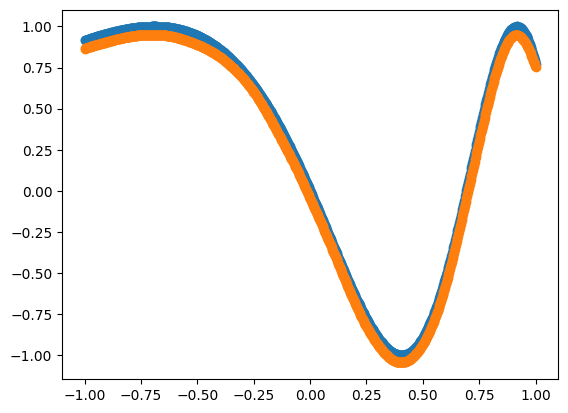

In [15]:
target_fn = lambda x: torch.sin(torch.pi * torch.exp(x))

x_train = torch.linspace(-1, 1, steps=1000).unsqueeze(1)
y_train = target_fn(x_train.detach().clone())

learn_rate = 0.01

model = KAN()
model.add_layer(ChebyKANLayer(1, 8, 8))
model.add_layer(ChebyKANLayer(8, 1, 8))

y_pred = model.train(x_train, y_train, learn_rate, 1000, prnt=True)

plt.scatter(x_train, y_train)
plt.scatter(x_train, y_pred.detach())